In [1]:
import sys 
import datetime

sys.path.insert(0, '../')

from constants import * 
import datasets
import loss_fns
import models
import util

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def keep_track_doy_crop(DOY_counts, DOY_sums, DOY_sums_sqd, inputs, targets, source):
    # For each input example and corresponding target,
    if source == 's1':
        doy_band_idx = 3
    elif source == 's2':
        doy_band_idx = 11
            
    for ex_idx in range(inputs.shape[0]):
        # For each band,
        for band_idx in range(inputs.shape[2]):
            # For each time stamp,
            if source == 's1' and band_idx == 3:
                pass
            elif source == 's2' and band_idx == 11:
                pass
            else:
                for time_idx in range(inputs.shape[1]):
                    # Index pixels of desired crop
                    for crop_idx in range(targets.shape[1]):
                        # Index into current pixels
                        cur_crop_vals = inputs[ex_idx, time_idx, band_idx, :, :]
                        cur_crop_vals = cur_crop_vals[targets[ex_idx, crop_idx, :, :] == 1]
                        
                        cur_doy = int(inputs[ex_idx, time_idx, doy_band_idx, 0, 0] * 177.5 + 177.5)
                        
                        # Put sum of pixels into correct band, doy element of DOY_sums
                        DOY_sums[band_idx, crop_idx, cur_doy] += np.sum(cur_crop_vals)

                        # Put sum of sqd pixels into correct band, doy element of DOY_sums_sqd
                        DOY_sums_sqd[band_idx, crop_idx, cur_doy] += np.sum(cur_crop_vals**2)
                        
                        # Put number of pixels into correct band, doy element of DOY_count
                        DOY_counts[band_idx, crop_idx, cur_doy] += len(cur_crop_vals)
                        
    return DOY_counts, DOY_sums, DOY_sums_sqd

In [3]:
def get_stats(model_name, args=None, dataloaders=None, num_bands=None):
    if num_bands == 4:
        source = 's1'
    elif num_bands == 12:
        source = 's2'
    
    if model_name in DL_MODELS:
        DOY_counts = None
        for split in ['train']:
            dl = dataloaders[split]
            for inputs, targets, cloudmasks in dl:
                
                if DOY_counts is None:
                    DOY_sums = np.zeros((num_bands, targets.shape[1], 365))
                    DOY_sums_sqd = np.zeros_like(DOY_sums)
                    DOY_counts = np.zeros_like(DOY_sums)
                    
                DOY_counts, DOY_sums, DOY_sums_sqd = keep_track_doy_crop(DOY_counts, DOY_sums, DOY_sums_sqd, inputs.numpy(), targets.numpy(), source)
                    
    return DOY_counts, DOY_sums, DOY_sums_sqd

In [4]:
train_parser = util.get_train_parser()
args = train_parser.parse_args(['--epochs', str(1),
                                '--model_name', 'fcn_crnn',
                                '--dataset', 'full', 
                                '--num_classes', str(4),
                                '--country', 'southsudan',
                                '--hdf5_filepath', '/home/roserustowicz/croptype_data_local/data/southsudan/data.hdf5',
                                '--grid_dir', '/home/roserustowicz/croptype_data_local/data/southsudan',
                                '--batch_size', str(1),
                                '--hidden_dims', str(4),
                                '--crnn_num_layers', str(1),
                                '--use_s1', str(True),
                                '--use_s2', str(False),
                                '--sample_w_clouds', str(False),
                                '--include_clouds', str(True),
                                '--include_doy', str(True),
                                '--bidirectional', str(False), 
                                '--shuffle', str(False),
                                '--normalize', str(False),
                                '--apply_transforms', str(False),
                                '--least_cloudy', str(False)])
    
# load in data generator
dataloaders = datasets.get_dataloaders(args.grid_dir, args.country, args.dataset, args)
    
if args.use_s1 == True and args.include_doy == True:
    num_bands = 4
elif args.use_s2 == True and args.include_doy == True and args.include_clouds == True:
    num_bands = 12
else:
    print("ERROR! Check input args for this script!")
            
DOY_counts, DOY_sums, DOY_sums_sqd = get_stats(args.model_name, args, dataloaders=dataloaders, num_bands=num_bands)
    
print('doy sums: ', DOY_sums.shape)
print('doy sums sqd: ', DOY_sums_sqd.shape)
print('doy count: ', DOY_counts.shape)

doy sums:  (4, 4, 365)
doy sums sqd:  (4, 4, 365)
doy count:  (4, 4, 365)


In [5]:
means = DOY_sums / (DOY_counts)
means[DOY_counts == 0] = 0
stds = np.sqrt( (DOY_sums_sqd / (DOY_counts)) - (DOY_sums / (DOY_counts))**2 )
stds[DOY_counts == 0] = 0



/home/roserustowicz/anaconda3/envs/croptype/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/roserustowicz/anaconda3/envs/croptype/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


(4, 4, 365)


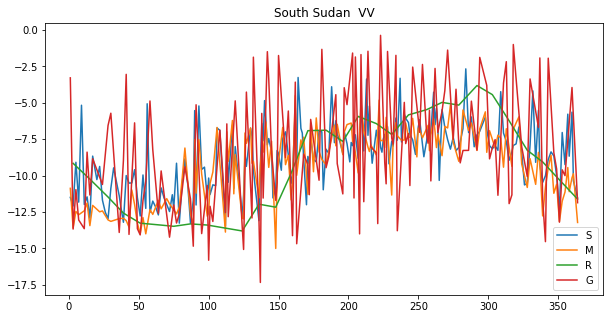

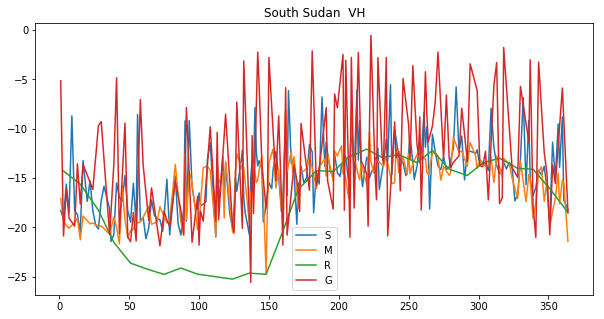

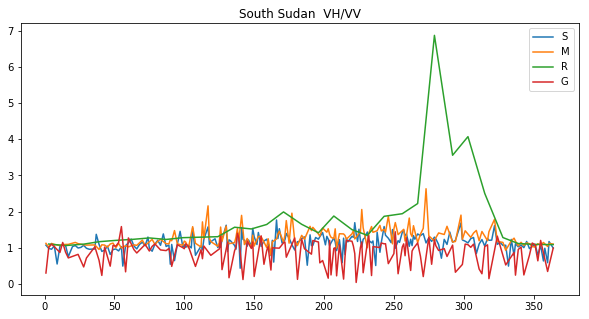

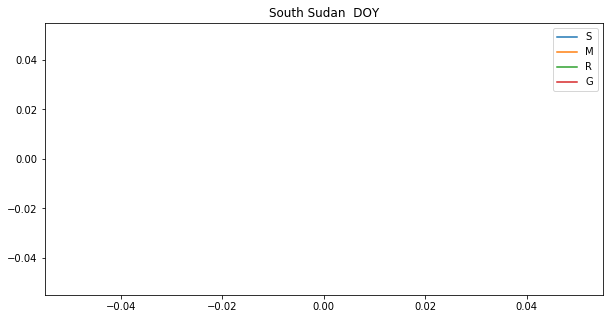

In [6]:
country = 'South Sudan '
print(means.shape)
s1_bands = {'0': 'VV', '1': 'VH', '2': 'VH/VV', '3': 'DOY'}
s2_bands = {'0': 'Blue', '1': 'Green', '2': 'Red', '3': 'Red Edge 1', '4': 'Red Edge 2', '5': 'Red Edge 3', 
            '6': 'NIR', '7': 'Red Edge 4', '8': 'SWIR 1', '9': 'SWIR 2', '10': 'Clouds', '11': 'DOY'}

if args.use_s1 == True:
    band_dict = s1_bands
elif args.use_s2 == True:
    band_dict = s2_bands

days = np.array(list(range(365)))
for band_idx in range(means.shape[0]):
    plt.figure(figsize=(10, 5));
    plt.title(country + ' ' + band_dict[str(band_idx)])
    for crop_idx in range(means.shape[1]):
        cur_means = means[band_idx, crop_idx, :]
        cur_days = days[cur_means != 0]
        cur_means_nonzero = cur_means[cur_means != 0]
        plt.plot(cur_days, cur_means_nonzero)
        plt.legend('SMRG')

## bnd_means = np.vstack(means_list)
print("Means: ", np.mean(bnd_means, axis=0))
print("+/- : ", np.std(bnd_means, axis=0))

bnd_stds = np.vstack(stds_list)

print("Stdevs: ", np.mean(bnd_stds, axis=0))
print("+/- : ", np.std(bnd_stds, axis=0))